# Pre-processing
### JPG TO NPY

We convert all the JPG images to .npy format so that they can be loaded onto numpy array easily and the model can be trained using these .npy files. The image files are stored within labelled directories, hence the function recursively goes through each directory and converts all jpg files to npy

In [1]:
import os
import cv2
import numpy as np

def jpg_to_npy_in_folders(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for i, item in enumerate(os.listdir(input_folder)):
        item_path = os.path.join(input_folder, item)
        if os.path.isdir(item_path):
            jpg_to_npy_in_folders(item_path, output_folder)
        elif os.path.isfile(item_path) and item.endswith(".jpg"):
            img = cv2.imread(item_path)
            img = cv2.resize(img, (256, 256)) 
            img_array = np.array(img)
            folder = input_folder.split("/")[-1]
            output_file_path = os.path.join(output_folder, f"{folder}{i}.npy")
            np.save(output_file_path, img_array)

input_folder_path = "/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/train"
output_folder_path = "/kaggle/working/train"

jpg_to_npy_in_folders(input_folder_path, output_folder_path)
jpg_to_npy_in_folders("/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test", "/kaggle/working/test")


In [2]:
import os
import numpy as np
directory = '/kaggle/working/train'

files = [file for file in os.listdir(directory) if file.endswith('.npy')]
len(files)


1101

### Class separation

All npy files are saved with the class name as part of the file name. Using this we can separate the files into different classes. Printing out the number of files for each class shows us that there is a slight imbalance.

The five classes that we will be able to detect with this dataset are

* AD - Alzheimer's Disease
* CN - Cognitively Normal
* EMCI - Early Mild Cognitive Impairment
* LMCI - Late Mild Cognitive Impairment
* MCI - Mild Cognitive Impairment

In [3]:
ad = [i for i in files if "AD" in i]
cn = [i for i in files if "CN" in i]
emci = [i for i in files if "EMCI" in i]
lmci = [i for i in files if "LMCI" in i]
mci = [i for i in files if " MCI " in i]
print(len(ad), len(cn), len(emci), len(lmci), len(mci))

145 493 204 61 198


We store all the file paths and their respective classes into a pandas dataframe for easy use in the future for processing tasks.

In [4]:
import pandas as pd
l = [[ad, 0], [cn, 1], [emci, 2], [lmci, 3], [mci, 4]]
x = []
for i in l:
    for j in i[0]:
        path = os.path.join("/kaggle/working/train", j)
        x.append([i[1], path])

df = pd.DataFrame(x, columns=["Class", "Path"])
x = df["Class"].value_counts()
x

Class
1    493
2    204
4    198
0    145
3     61
Name: count, dtype: int64

The model takes an input shape of `(256, 256, 3)`. Our initial work into the dataset showed us that there were 50 images not having this shape. We reshaped the images before converting them to npy in the final version. This cell checks if there are any image that do not have the necessary shape.

In [5]:
for j, i in enumerate(df["Path"]):
    if np.load(i).shape != (256, 256, 3):
        print(i)


# Handling imbalance


Loading images into memory for processing

In [6]:
images = []
for i in df["Path"]:
    images.append(np.load(i))
images = np.array(images)

In [7]:
images = images.reshape((1101, 196608))

Reshaping each image array into separate row

### SMOTE

SMOTE for image data does not work effectively, since SMOTE essentially works by finding the K-Nearest Neighbours and taking the average of points between two clusters. The images obtained this way were very noisy and not close to the original images we had and only caused more problems in training the model. All forms of oversampling or undersampling imvolving average of points were ruled out because of the poor quality of images obtained. 

In [8]:
from imblearn.over_sampling import SMOTE
import random
import matplotlib.pyplot as plt

smote = SMOTE()
sm = SMOTE(random_state=42)
images, labels = sm.fit_resample(images, df["Class"])



Majority of the images showed very poor quality and were not usable.

In [9]:
images = images.reshape((2465, 256, 256, 3))

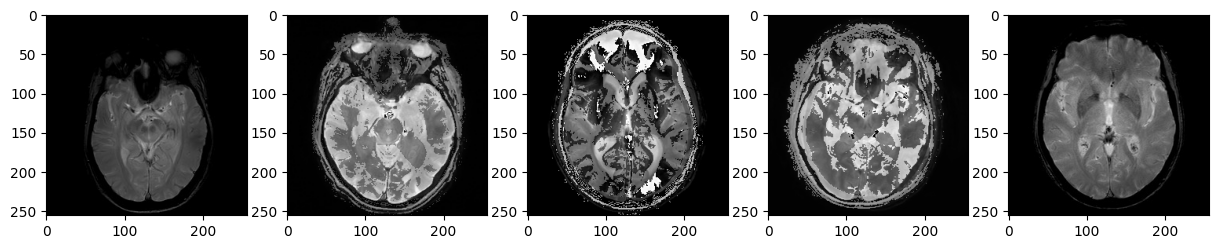

In [10]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3)) 

for i in range(5):
    img = random.choice(images)
    axs[i].imshow(img)

plt.show()

### Random oversampling

Instead of using averaging imbalanced techniques, we used Random Oversampling to simply increase the number of samples of the imbalanced classes. This yielded big improvements in both the validation and test data.

In [11]:
from imblearn.over_sampling import RandomOverSampler
path = np.array(df["Path"]).reshape(-1, 1)
classes = np.array(df["Class"]).reshape(-1, 1)
ros = RandomOverSampler(random_state=42)
paths, oversampled_labels = ros.fit_resample(path, classes)
df = pd.DataFrame({
    'Path': paths.flatten(),
    'Class': oversampled_labels
})
df


,Path,Class
0,/kaggle/working/train/Final AD JPEG39.npy,0
1,/kaggle/working/train/Final AD JPEG17.npy,0
2,/kaggle/working/train/Final AD JPEG53.npy,0
3,/kaggle/working/train/Final AD JPEG127.npy,0
4,/kaggle/working/train/Final AD JPEG86.npy,0
...,...,...
2460,/kaggle/working/train/Final MCI JPEG112.npy,4
2461,/kaggle/working/train/Final MCI JPEG10.npy,4
2462,/kaggle/working/train/Final MCI JPEG177.npy,4
2463,/kaggle/working/train/Final MCI JPEG187.npy,4


Loading images into memory for training

In [12]:
images = []
for i in df["Path"]:
    images.append(np.load(i))
images = np.array(images)

In [13]:
x = df["Class"].value_counts()
x

Class
0    493
1    493
2    493
3    493
4    493
Name: count, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
labels = np.array(df["Class"])
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


In [15]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=5)
val_labels = to_categorical(val_labels, num_classes=5)

2024-04-22 16:24:02.827144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 16:24:02.827245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 16:24:02.974923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
print(train_images.shape, val_images.shape, train_labels.shape, val_labels.shape)

(1972, 256, 256, 3) (493, 256, 256, 3) (1972, 5) (493, 5)


# Training

We use CNNs for training because of their ability to recognise patterns in images. The convolutional and pooling layers makes it easy to reduce dimensions and prevent overfitting. Each layer can detect an increasing complexity in the pattern. The Dense layers are added at the end to globally interpret the local patterns extracted from the images by the convolutional layers. The final layer usually has a softmax activation which gives us the probabilities of an image belonging to each class.

### The actual model

In the model used by us, we have 3 hidden convolutional layers along with pooling layers. All of them use ReLU activation to learn the complex patterns by allowing non linear tranformations. We then add a flatten layer so that the 3 consequent Dense layers can reduce dimensionality one by one and finally interpret which of the five classes the image belongs to. The model summary shows the number of weights at each layer.

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = train_images[0].shape

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   117,965,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,402,437 (451.67 MB)

 Trainable params: 118,402,437 (451.67 MB)

 Non-trainable params: 0 (0.00 B)

### Optimiser and Learning Rate Scheduler

The adam optimiser is used because it is very memory efficient, which is necessary while using image data, since the training data size can get very big. A custom learning rate scheduler is defined along with the optimiser to reduce the learning rate by 5% every two epochs after the 20th epoch. While training initially, we noticed the model overshot after the 20th epoch and wasnt able to train efficiently. Hence the scheduler helps to prevent overshooting and imporves the rate at which the model can converge. 

In [18]:
from keras.optimizers import Adam
def lr_schedule(epoch, learning_rate):
    if epoch < 20:
        return learning_rate
    else:
        if epoch % 2 == 0:
            return learning_rate * 0.95
        else:
            return learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

### Metrics

We have defined a custom F1 score metric since we couldn't find a reliable one on any library. It finds recall and precision and following tensorflow API requirements, there are `update_state` and `reset_state`methods that handle batching durinng training. The metrics we finally use while training to measure the performance of the model are Categorical Accuracy, ROC-AUC and F1 score.

In [19]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(F1Score, self).__init__(**kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           F1Score()]


### Threshold Callback

To prevent overfitting and as a rule of thumb, we set validation accuracy of 0.995 to be the threshold at which convergence should've occured and stop the training of the model at that point. The threshold callback and the learning rate scheduler are the two callbacks we use for training. 

In [20]:
class ThresholdCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.995:
            print("\nReached accuracy threshold")
            self.model.stop_training = True

threshCallback = ThresholdCallBack()
CALLBACKS = [lr_scheduler, threshCallback]

### Model Fitting

Finally we train the model for 60 epochs on 2 T4 GPUS using categorical cross entropy as a loss function, since our model is a classifier that needs to predict classes.

In [21]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICS)

history = model.fit(
    train_images, train_labels,
    epochs=60,
    validation_data=(val_images, val_labels),
    callbacks=CALLBACKS)  


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60
 1/62 ━━━━━━━━━━━━━━━━━━━━ 29:37 29s/step - acc: 0.1875 - auc: 0.4561 - f1_score: 0.1875 - loss: 13.5945

I0000 00:00:1713803085.202233      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713803085.220412      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - acc: 0.1950 - auc: 0.5021 - f1_score: 0.0847 - loss: 38.3990

W0000 00:00:1713803114.750642      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713803116.438745      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 65s 594ms/step - acc: 0.1951 - auc: 0.5023 - f1_score: 0.0839 - loss: 37.9838 - val_acc: 0.2961 - val_auc: 0.5836 - val_f1_score: 0.0000e+00 - val_loss: 1.5798 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - acc: 0.1875 - auc: 0.5261 - f1_score: 0.0000e+00 - loss: 1.6026

W0000 00:00:1713803121.596313      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - acc: 0.2740 - auc: 0.5841 - f1_score: 0.0386 - loss: 1.5741 - val_acc: 0.3793 - val_auc: 0.6821 - val_f1_score: 0.0873 - val_loss: 1.4741 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - acc: 0.3403 - auc: 0.6688 - f1_score: 0.1553 - loss: 1.4699 - val_acc: 0.4645 - val_auc: 0.7889 - val_f1_score: 0.3148 - val_loss: 1.2746 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - acc: 0.4544 - auc: 0.7626 - f1_score: 0.3357 - loss: 1.2804 - val_acc: 0.5882 - val_auc: 0.8535 - val_f1_score: 0.4733 - val_loss: 1.0806 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - acc: 0.5552 - auc: 0.8461 - f1_score: 0.4739 - loss: 1.0876 - val_ac

In [22]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score

y_prob = model.predict(val_images)
roc_auc = roc_auc_score(val_labels, y_prob, average='macro')

print("ROC AUC:", roc_auc)

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

W0000 00:00:1713803666.738412      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
ROC AUC: 0.9895261004515495


W0000 00:00:1713803667.525610      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Saving the model

The model is saved for the future so that it can be combined with the handwriting classifier later on

In [23]:
model.save("my_cnn_model.h5")


# Testing

In [24]:
import os
import numpy as np
directory = '/kaggle/working/test'

files = [file for file in os.listdir(directory) if file.endswith('.npy')]
len(files)

195

### Data loading

The test npy file paths are separated into lists for the purpose of classification. 

In [25]:
ad = [i for i in files if "AD" in i]
cn = [i for i in files if "CN" in i]
emci = [i for i in files if "EMCI" in i]
lmci = [i for i in files if "LMCI" in i]
mci = [i for i in files if " MCI " in i]
print(len(ad), len(cn), len(emci), len(lmci), len(mci))

26 87 36 11 35


The paths are added into a dataframe with labels

In [26]:
import pandas as pd
l = [[ad, 0], [cn, 1], [emci, 2], [lmci, 3], [mci, 4]]
x = []
for i in l:
    for j in i[0]:
        path = os.path.join("/kaggle/working/train", j)
        x.append([i[1], path])

df = pd.DataFrame(x, columns=["Class", "Path"])
x = df["Class"].value_counts()
x

Class
1    87
2    36
4    35
0    26
3    11
Name: count, dtype: int64

Checking the test data for images that do not fit the input size of the model

In [27]:
for j, i in enumerate(df["Path"]):
    if np.load(i).shape != (256, 256, 3):
        print(i)

Loading the test images into memory for prediction

In [28]:
images = []
for i in df["Path"]:
    images.append(np.load(i))
images = np.array(images)

### Prediction

The model makes predictions based on the test images given to it. The predictions are in the form of a vector of size 5, where each element gives the probability of the image belonging to a certain class. We use the numpy `argmax` function to find the index of the element with the highest probability and conclude that the given image belongs to that class.

In [29]:
y_prob = model.predict(images)

y_prob = np.argmax(y_prob, axis=1)  

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step


W0000 00:00:1713803682.688535      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Results

Making use of the `classification_report` module in both sklearn and imblearn, we can plot the overall performance of the model against new, unseen test data and we can see that the model performs pretty well with an accuracy and F1 score of 0.97. We can thus conclude that the training has been pretty successful and the model can generalise well enough on any form of unseen data. 

In [30]:
from sklearn.metrics import classification_report
l = df["Class"]
print(classification_report(y_prob, l, target_names=["Alzheimer's Disease" , "Cognitively Normal",  "Early Mild Cognitive Impairment","Mild Cognitive Impairment","ate Mild Cognitive Impairment"]))

                                 precision    recall  f1-score   support

            Alzheimer's Disease       1.00      1.00      1.00        26
             Cognitively Normal       0.93      0.99      0.96        82
Early Mild Cognitive Impairment       0.97      0.95      0.96        37
      Mild Cognitive Impairment       1.00      0.92      0.96        12
  ate Mild Cognitive Impairment       1.00      0.92      0.96        38

                       accuracy                           0.96       195
                      macro avg       0.98      0.95      0.97       195
                   weighted avg       0.97      0.96      0.96       195



In [31]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(l, y_prob))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00        26
          1       0.99      0.93      0.99      0.96      0.96      0.92        87
          2       0.95      0.97      0.99      0.96      0.98      0.96        36
          3       0.92      1.00      0.99      0.96      1.00      1.00        11
          4       0.92      1.00      0.98      0.96      0.99      0.98        35

avg / total       0.97      0.96      0.99      0.96      0.98      0.95       195



In [32]:
from keras.utils import to_categorical
labels = to_categorical(l)
model.evaluate(images, labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - acc: 0.9546 - auc: 0.9924 - f1_score: 0.9463 - loss: 0.2190


W0000 00:00:1713803687.384580      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.18541263043880463, 0.964102566242218, 0.993096649646759, 0.9587628245353699]


### Confusion Matrix

A confusion matrix to visualise the predictions of the model and show its performance.

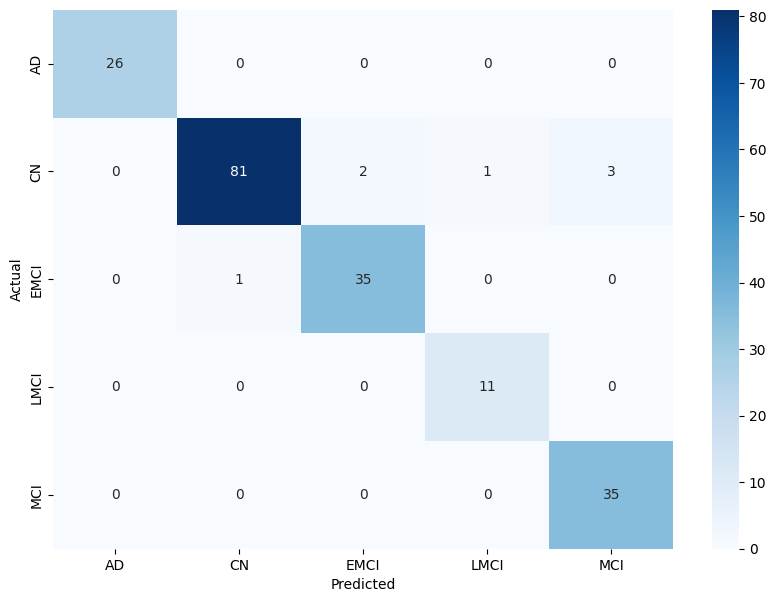

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(l, y_prob)

class_names = ['AD', 'CN', 'EMCI', 'LMCI', 'MCI']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()